In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
def scale_non_nan(X):
    scaler = StandardScaler()
    X_scaled = X.copy()
    for col in X.columns:
        mask = X[col].notna()
        
        if mask.sum() > 3:
            X_scaled.loc[mask, col] = scaler.fit_transform(X[[col]].loc[mask].values.reshape(-1, 1)).flatten()
    return X_scaled

def non_nan_scaler(X):
    return scale_non_nan(X)

In [3]:
with open('model_dict.pkl', 'rb') as file:
    loaded_model_dict = pickle.load(file)
with open('./FunDataCleaned.pkl', 'rb') as f:
    fun_data = pickle.load(f)

C:\Users\28604\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\28604\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
cutoff_date = pd.to_datetime("2020-01-01")

combined_predictions_df = pd.DataFrame()

for stock, model_info in loaded_model_dict.items():

    pipeline = model_info['pipeline']

    data_after_2020 = fun_data[stock][fun_data[stock].index >= cutoff_date].copy()
    
    data_after_2020['ret'] = data_after_2020['ret'].shift(-1)
    
    data_after_2020.dropna(subset=['ret'], inplace=True)
    first_5_cols = data_after_2020.columns[:5]
    data_after_2020 = data_after_2020[~(data_after_2020[first_5_cols].isna().sum(axis=1) >= 3)]
    
    if data_after_2020.empty:
        continue

    X_test = data_after_2020.drop(columns=['ret', 'Adj_close_price'])

    predictions = pipeline.predict(X_test)
    
    temp_df = pd.DataFrame(predictions, index=X_test.index, columns=[stock])
    
    combined_predictions_df = combined_predictions_df.merge(temp_df, left_index=True, right_index=True, how='outer')

combined_predictions_df.head()

AttributeError: 'FunctionTransformer' object has no attribute 'feature_names_out'

In [6]:
def top_25_percent_positive(row):
    # Filter out NaN and non-positive values
    positive_values = row[row > 0].dropna()
    # Calculate the 75th percentile threshold
    threshold = positive_values.quantile(0.75)
    # Return stocks that are in the top 25% and greater than the threshold
    return positive_values[positive_values >= threshold].index.tolist()

# Apply the function to each row and store results in a new DataFrame column
combined_predictions_df['Top_25_percent_positive'] = combined_predictions_df.apply(top_25_percent_positive, axis=1)

# Display the top rows of the DataFrame to verify results
combined_predictions_df[['Top_25_percent_positive']].head()

,Top_25_percent_positive


In [12]:
combined_predictions_dfS

,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,601989,601998,603019,603369,603799,603806,603899,603986,603993,Top_25_percent_positive
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,-0.113370,0.415615,-0.103539,-0.051967,-0.046121,-0.066335,-0.227818,-0.056909,-0.144592,0.185473,...,-0.060138,-0.173329,-0.304509,-0.357755,-0.396471,-0.728607,-0.180657,-0.198605,-0.077349,"[000002, 000617, 000625, 000776, 000963, 00205..."
2020-06-30,0.364982,0.116584,-0.060842,0.183154,-0.068407,-0.047381,-0.117185,-0.259744,-0.349533,0.153667,...,0.089730,-0.001458,0.235920,-0.023347,-0.396471,-0.728607,-0.180657,0.166105,-0.201934,"[000001, 000617, 000776, 000807, 000963, 00205..."
2020-09-30,-0.147114,0.452115,0.032141,0.183154,0.232952,0.024658,-0.223571,0.217234,-0.398396,0.319453,...,0.084721,0.025140,-0.304120,0.156735,-0.396471,0.386004,0.019296,-0.100810,-0.183690,"[000002, 000157, 000333, 000408, 000617, 00077..."
2020-12-31,0.357048,0.012180,0.050442,0.183342,0.068413,0.046785,0.011560,-0.061283,0.149942,0.147412,...,-0.006576,-0.025979,-0.014996,0.158013,-0.194637,0.176593,0.002786,0.155171,-0.175772,"[000001, 000425, 000651, 000768, 000776, 00080..."
2021-03-31,-0.212536,-0.120228,0.274560,-0.012330,0.116671,0.024382,-0.211166,0.276616,0.055495,0.225774,...,-0.057696,-0.051646,0.183562,0.013630,0.121082,-0.195681,-0.008918,0.110736,-0.076844,"[000063, 000333, 000408, 000596, 000617, 00079..."
2021-06-30,0.438793,0.150891,0.100337,0.035270,0.041397,0.028137,-0.020824,0.230504,-0.015152,0.239093,...,0.110933,-0.026763,-0.187242,-0.086392,0.121082,0.058498,0.007978,0.513759,0.136109,"[000001, 000333, 000408, 000568, 000617, 00062..."
2021-09-30,-0.115770,-0.090870,0.152893,0.241288,0.141786,0.094019,-0.109613,0.230775,0.239007,0.096993,...,-0.060511,0.057720,0.135793,-0.002757,-0.082490,0.036369,-0.039851,-0.320601,0.014110,"[000100, 000333, 000338, 000625, 000661, 00070..."
2021-12-31,0.192560,0.070447,0.256586,0.110902,0.063659,-0.010414,-0.021077,0.165130,0.050850,-0.121261,...,-0.057696,0.071436,-0.052501,0.113731,0.098665,0.069020,0.122358,-0.041886,0.156823,"[000001, 000063, 000776, 000963, 000977, 00202..."
2022-03-31,0.006101,-0.076031,0.238771,-0.046567,0.401211,-0.081547,-0.172918,0.142001,-0.382989,0.173488,...,0.110530,0.037648,0.134607,0.016486,-0.373710,0.042350,0.156748,0.163315,0.069449,"[000063, 000157, 000651, 000708, 000895, 00202..."


In [7]:
combined_predictions_df = combined_predictions_df[combined_predictions_df.isna().mean(axis=1) <= 0.5]

nan_ratios = combined_predictions_df.isna().mean(axis=1)

max_nan_ratio = nan_ratios.max()

max_nan_ratio

0.0044444444444444444

In [20]:
actual_returns_series

Date
2020-03-31    4.669191
2020-06-30    2.595546
2020-09-30    4.115922
2020-12-31   -0.906658
2021-03-31    3.580823
2021-06-30    2.183659
2021-09-30    0.384333
2021-12-31   -5.835783
2022-03-31    1.267467
2022-06-30   -5.862257
2022-09-30    1.108425
2022-12-31    2.979130
2023-03-31   -2.666081
2023-06-30   -2.531427
2023-09-30   -1.668440
2023-12-31   -1.035407
2024-03-31   -3.281438
2024-06-30    5.857075
dtype: float64

In [19]:
cumulative_returns

Date
2020-03-31     4.669191
2020-06-30     7.264736
2020-09-30    11.380658
2020-12-31    10.474000
2021-03-31    14.054823
2021-06-30    16.238482
2021-09-30    16.622815
2021-12-31    10.787032
2022-03-31    12.054499
2022-06-30     6.192242
2022-09-30     7.300667
2022-12-31    10.279796
2023-03-31     7.613716
2023-06-30     5.082289
2023-09-30     3.413848
2023-12-31     2.378442
2024-03-31    -0.902996
2024-06-30     4.954078
dtype: float64

In [12]:
combined_predictions_df = pd.read_csv('Fun_predictions.csv')
combined_predictions_df['Date'] = pd.to_datetime(combined_predictions_df['Date'])
combined_predictions_df.set_index('Date', inplace=True)

In [13]:
combined_predictions_df.to_csv('Fun_predictions.csv')

In [13]:
combined_predictions_df

,000001,000002,000063,000100,000157,000166,000301,000333,000338,000408,...,601989,601998,603019,603369,603799,603806,603899,603986,603993,Top_25_percent_positive
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,-0.113370,0.415615,-0.103539,-0.051967,-0.046121,-0.066335,-0.227818,-0.056909,-0.144592,0.185473,...,-0.060138,-0.173329,-0.304509,-0.357755,-0.396471,-0.728607,-0.180657,-0.198605,-0.077349,"['000002', '000617', '000625', '000776', '0009..."
2020-06-30,0.364982,0.116584,-0.060842,0.183154,-0.068407,-0.047381,-0.117185,-0.259744,-0.349533,0.153667,...,0.089730,-0.001458,0.235920,-0.023347,-0.396471,-0.728607,-0.180657,0.166105,-0.201934,"['000001', '000617', '000776', '000807', '0009..."
2020-09-30,-0.147114,0.452115,0.032141,0.183154,0.232952,0.024658,-0.223571,0.217234,-0.398396,0.319453,...,0.084721,0.025140,-0.304120,0.156735,-0.396471,0.386004,0.019296,-0.100810,-0.183690,"['000002', '000157', '000333', '000408', '0006..."
2020-12-31,0.357048,0.012180,0.050442,0.183342,0.068413,0.046785,0.011560,-0.061283,0.149942,0.147412,...,-0.006576,-0.025979,-0.014996,0.158013,-0.194637,0.176593,0.002786,0.155171,-0.175772,"['000001', '000425', '000651', '000768', '0007..."
2021-03-31,-0.212536,-0.120228,0.274560,-0.012330,0.116671,0.024382,-0.211166,0.276616,0.055495,0.225774,...,-0.057696,-0.051646,0.183562,0.013630,0.121082,-0.195681,-0.008918,0.110736,-0.076844,"['000063', '000333', '000408', '000596', '0006..."
2021-06-30,0.438793,0.150891,0.100337,0.035270,0.041397,0.028137,-0.020824,0.230504,-0.015152,0.239093,...,0.110933,-0.026763,-0.187242,-0.086392,0.121082,0.058498,0.007978,0.513759,0.136109,"['000001', '000333', '000408', '000568', '0006..."
2021-09-30,-0.115770,-0.090870,0.152893,0.241288,0.141786,0.094019,-0.109613,0.230775,0.239007,0.096993,...,-0.060511,0.057720,0.135793,-0.002757,-0.082490,0.036369,-0.039851,-0.320601,0.014110,"['000100', '000333', '000338', '000625', '0006..."
2021-12-31,0.192560,0.070447,0.256586,0.110902,0.063659,-0.010414,-0.021077,0.165130,0.050850,-0.121261,...,-0.057696,0.071436,-0.052501,0.113731,0.098665,0.069020,0.122358,-0.041886,0.156823,"['000001', '000063', '000776', '000963', '0009..."
2022-03-31,0.006101,-0.076031,0.238771,-0.046567,0.401211,-0.081547,-0.172918,0.142001,-0.382989,0.173488,...,0.110530,0.037648,0.134607,0.016486,-0.373710,0.042350,0.156748,0.163315,0.069449,"['000063', '000157', '000651', '000708', '0008..."


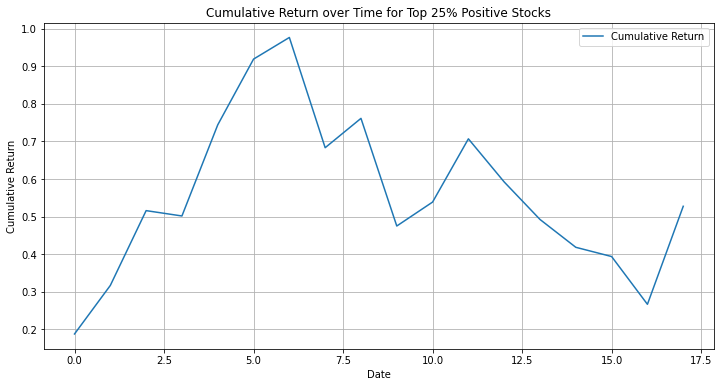

In [17]:
import ast
actual_returns = []

# Iterate over each row in combined_predictions_df to calculate actual returns
for date, row in combined_predictions_df.iterrows():
    # Get the list of stocks in the top 25% positive for this date
    top_stocks = ast.literal_eval(row['Top_25_percent_positive'])
    
    # Skip dates with no top stocks
    if not top_stocks:
        actual_returns.append(0)  # Or np.nan if you want to indicate missing data
        continue

    # Initialize the total return for this date
    total_ret = 0

    # Retrieve and sum up the shifted 'ret' values for each top stock from fun_data
    for stock in top_stocks:
        # Get the shifted 'ret' for this stock on this date
        try:
            shifted_ret = fun_data[stock]['ret'].shift(-1).loc[date]  # Access the ret value shifted up by one
            # Only add if it's a valid number (not NaN)
            if pd.notna(shifted_ret):
                total_ret += np.exp(shifted_ret)
        except KeyError:
            # If the date or stock is missing, continue
            continue

    # Append the calculated total return to the actual_returns list
    actual_returns.append(total_ret/len(top_stocks))

# Create a Series from actual_returns with the same index as combined_predictions_df
actual_returns_series = pd.Series(actual_returns, index=combined_predictions_df.index)

# Compute the cumulative sum
cumulative_returns = np.cumprod(actual_returns_series) - 1

# Plot the cumulative returns over time
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.values, label="Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return over Time for Top 25% Positive Stocks")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
np.std(actual_returns_series)

0.1099620086730112

[*********************100%%**********************]  1 of 1 completed


C:\Users\28604\anaconda3\lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


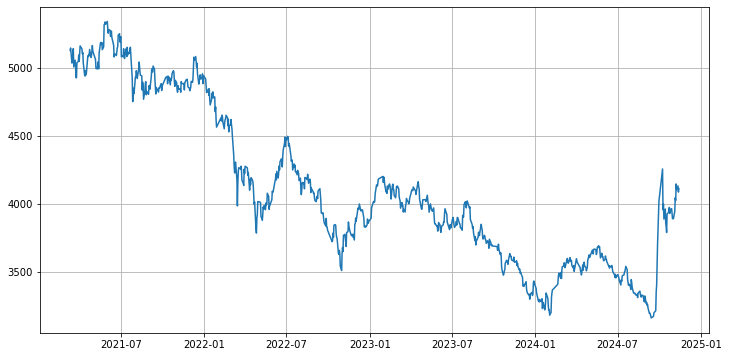

In [28]:
start_date = '2020-01-01'
ticker = '000300.SS'  # 沪深300指数的代码
data = yf.download(ticker, start=start_date)

# 绘制价格走势折线图
plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'])
plt.grid()
plt.show()